# Text classification task: Bag of Words Approach SVD attempt

Trying the SVD approach to reduce the sparsity in the Count-vectorizer resulting Cooccurrence matrix
## TL;DR



## Packages

In [2]:
#---- magic trio + special guest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#---- utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint 
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
import time

In [3]:
df = pd.read_pickle("../data/df_preprocessed_eng_remap.pckle")

df.head()

,description,event_id,category,category_label,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords,remap_category,remap_category_label
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,language/ethnic identity,15,English,99,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,language/ethnic identity,11
1,"<p>Free, unauditioned, collaborative pop choir...",gpjktmywhbnb,music,18,English,99,sing us free unaudit collabor pop choir identi...,sing u free unauditioned collaborative pop cho...,sing us unaudit collabor pop choir identifi wo...,sing u unauditioned collaborative pop choir id...,music,13
2,"<p>We provide a forum to learn about, promote ...",drrtzmywhbgb,career/business,3,English,98,east valley busi network meetup provid forum l...,east valley business network meetup provide fo...,east valley busi network provid forum learn pr...,east valley business network provide forum lea...,career/business,1
3,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,239719229,socializing,27,English,92,friendli friday whynot japan meetup collabor e...,friendly friday whynot japan meetup collaborat...,friendli whynot japan collabor whynot japan si...,friendly whynot japan collaboration whynot jap...,socializing,20
4,<p>This is an introductory meeting to get to k...,mtzxwmywjbjb,tech,30,English,99,authent option introductori meet get know fell...,authentication option introductory meet get kn...,authent option introductori get fellow coder s...,authentication option introductory get fellow ...,tech,22


# Text representation 

In [4]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = None, sublinear_tf = True)

X_data_tf_sparse = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)

count_vect = CountVectorizer(max_features = None, analyzer = 'word', ngram_range = (1,1))

X_data_count_sparse = count_vect.fit_transform(df.desc_lemm_no_badwords)

In [7]:
print(X_data_tf_sparse.getnnz())
density = X_data_tf_sparse.getnnz() / np.prod(X_data_tf_sparse.shape)
print("density", round(density*100, 2) , "%")

7731409
density 0.04 %


In [8]:
print(X_data_count_sparse.getnnz())
density = X_data_count_sparse.getnnz() / np.prod(X_data_count_sparse.shape)
print("density of initial count features", round(density*100, 2) , "%")

7884401
density of initial count features 0.03 %


In [10]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = 5000, sublinear_tf = True)

X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)

count_vect = CountVectorizer(max_features = 5000, analyzer = 'word', ngram_range = (1,1))

X_data_count = count_vect.fit_transform(df.desc_lemm_no_badwords)

In [11]:
print(X_data_tf.getnnz())
density = X_data_tf.getnnz() / np.prod(X_data_tf.shape)
print("density", round(density*100, 2) , "%")

6359568
density 1.75 %


In [12]:
print(X_data_count.getnnz())
density = X_data_count.getnnz() / np.prod(X_data_count.shape)
print("density of initial count features", round(density*100, 2) , "%")

6180465
density of initial count features 1.71 %


# Attempt with count

In [29]:
co_occurrence_matrix_count = (X_data_count.T* X_data_count)
co_occurrence_matrix_count.setdiag(0)


In [12]:
print(co_occurrence_matrix_count.getnnz())
density = co_occurrence_matrix_count.getnnz() / np.prod(co_occurrence_matrix_count.shape)
print("density of co-occurrence matrix", round(density*100, 2) , "%")

print(co_occurrence_matrix_count.todense())

19189818
density of co-occurrence matrix 76.76 %
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


A Jupyter Widget

Number of components = 10 and explained variance = 0.1973, exec time: 2.9 s
Number of components = 20 and explained variance = 0.2697, exec time: 3.75 s
Number of components = 50 and explained variance = 0.3686, exec time: 7.2 s
Number of components = 100 and explained variance = 0.4598, exec time: 12.7 s
Number of components = 200 and explained variance = 0.5643, exec time: 21.82 s
Number of components = 500 and explained variance = 0.7202, exec time: 53.56 s
Number of components = 1000 and explained variance = 0.8363, exec time: 115.27 s
Number of components = 2000 and explained variance = 0.9303, exec time: 249.13 s
Number of components = 3000 and explained variance = 0.97, exec time: 411.42 s



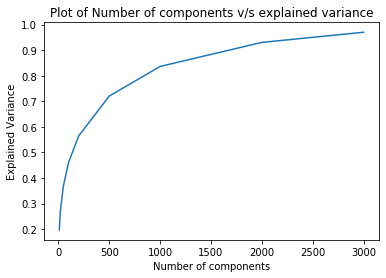

In [24]:
#SVD over count-vectorized data
from tqdm.autonotebook import tqdm
from sklearn.decomposition import TruncatedSVD
n_comp = [10,20,50,100,200,500,1000, 2000, 3000] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    t0 = time.time()
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_data_count)
    explained.append(svd.explained_variance_ratio_.sum())
    
    print("Number of components = %r and explained variance = %r, exec time: %r s"%(x,round(svd.explained_variance_ratio_.sum(), 4), round(time.time()-t0, 2)))
    

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

A Jupyter Widget

Number of components = 2 and explained variance = 0.6892635626683674
Number of components = 4 and explained variance = 0.7849838667025993
Number of components = 10 and explained variance = 0.8772547605373138
Number of components = 15 and explained variance = 0.905631524513589
Number of components = 20 and explained variance = 0.9231640145491684
Number of components = 50 and explained variance = 0.964543919840731
Number of components = 100 and explained variance = 0.9808738467584595
Number of components = 150 and explained variance = 0.986985192946743
Number of components = 200 and explained variance = 0.990262415391244
Number of components = 500 and explained variance = 0.9970705932344939
Number of components = 1000 and explained variance = 0.9991917743839193



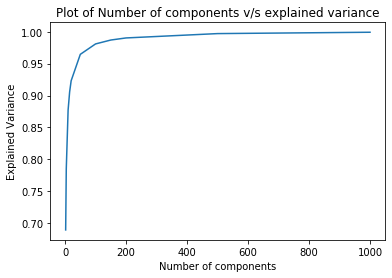

In [17]:
#SVD over co-occurrence matrix 
n_comp = [2,4,10,15,20,50,100,150,200,500,1000] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    svd = TruncatedSVD(n_components=x)
    svd.fit(co_occurrence_matrix_count)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [34]:
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_count, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6913748861849185

In [35]:
svd = TruncatedSVD(n_components=1000)
X_data_reduced = svd.fit_transform(X_data_count)
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   36.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6227961261484977

In [38]:
%%time
svd = TruncatedSVD(n_components=3000)
X_data_reduced = svd.fit_transform(X_data_count)
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


CPU times: user 1h 26min 36s, sys: 31min 2s, total: 1h 57min 39s
Wall time: 8min 32s


[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6073586623623872

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
X_data_reduced = pca.fit_transform(X_data_count.toarray())
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   32.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


0.6214303451701018

# Attempt with tfidf features

A Jupyter Widget

Number of components = 10 and explained variance = 0.0629, exec time: 2.76 s
Number of components = 20 and explained variance = 0.0933, exec time: 4.19 s
Number of components = 50 and explained variance = 0.153, exec time: 7.6 s
Number of components = 100 and explained variance = 0.2212, exec time: 12.67 s
Number of components = 200 and explained variance = 0.3159, exec time: 21.83 s
Number of components = 500 and explained variance = 0.491, exec time: 57.45 s
Number of components = 1000 and explained variance = 0.6584, exec time: 115.92 s
Number of components = 2000 and explained variance = 0.832, exec time: 258.05 s
Number of components = 3000 and explained variance = 0.9237, exec time: 428.93 s



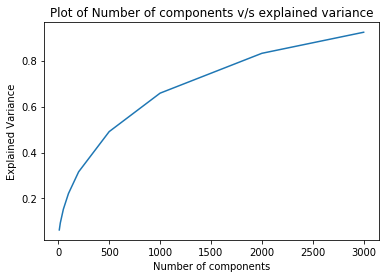

In [39]:
#SVD over count-vectorized data
from tqdm.autonotebook import tqdm
from sklearn.decomposition import TruncatedSVD
n_comp = [10,20,50,100,200,500,1000, 2000, 3000] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    t0 = time.time()
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_data_tf)
    explained.append(svd.explained_variance_ratio_.sum())
    
    print("Number of components = %r and explained variance = %r, exec time: %r s"%(x,round(svd.explained_variance_ratio_.sum(), 4), round(time.time()-t0, 2)))
    

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [41]:
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_tf, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6912507242777916

In [42]:
%%time
svd = TruncatedSVD(n_components=300)
X_data_reduced = svd.fit_transform(X_data_tf)
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


CPU times: user 10min 15s, sys: 2min 56s, total: 13min 12s
Wall time: 49.4 s


[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


0.6499048092045361

In [43]:
%%time
svd = TruncatedSVD(n_components=1000)
X_data_reduced = svd.fit_transform(X_data_tf)
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   26.8s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


CPU times: user 25min 47s, sys: 10min 27s, total: 36min 14s
Wall time: 2min 24s


[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.7s finished


0.6383163645393594

In [44]:
%%time
svd = TruncatedSVD(n_components=3000)
X_data_reduced = svd.fit_transform(X_data_tf)
y_data = df.remap_category_label

print("fitting")
X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
rf = rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
score

fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   53.8s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


CPU times: user 1h 21min 38s, sys: 30min 27s, total: 1h 52min 6s
Wall time: 8min 9s


[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6201887260988329

In [4]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = None, sublinear_tf = True)

X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)


A Jupyter Widget

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


10 0.5824848936346328
Number of components = 10 and classification score = 0.582, exec time: 6.64 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


20 0.6147669894876252
Number of components = 20 and classification score = 0.615, exec time: 8.39 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


50 0.6417101233341611
Number of components = 50 and classification score = 0.642, exec time: 14.01 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


100 0.6493667742736529
Number of components = 100 and classification score = 0.649, exec time: 22.19 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


200 0.6512292028805562
Number of components = 200 and classification score = 0.651, exec time: 36.11 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   21.0s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


500 0.6451452694313384
Number of components = 500 and classification score = 0.645, exec time: 75.92 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


1000 0.6383577518417349
Number of components = 1000 and classification score = 0.638, exec time: 143.88 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   40.0s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


2000 0.6269348563860607
Number of components = 2000 and classification score = 0.627, exec time: 303.63 s


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   47.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


3000 0.6187401705156858
Number of components = 3000 and classification score = 0.619, exec time: 478.42 s



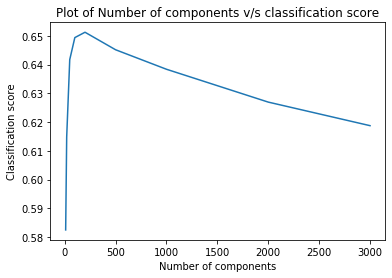

In [45]:
n_comp = [10,20,50,100,200,500,1000, 2000, 3000] # list containing different values of components
scores = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    t0 = time.time()
    svd = TruncatedSVD(n_components=x)
    X_data_reduced = svd.fit_transform(X_data_tf)
    X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
    rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
    rf = rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    scores.append(score)
    
    print("Number of components = %r and classification score = %r, exec time: %r s"%(x,round(score, 3), round(time.time()-t0, 2)))
    

plt.plot(n_comp, scores)
plt.xlabel('Number of components')
plt.ylabel("Classification score")
plt.title("Plot of Number of components v/s classification score")
plt.show()

In [12]:
svd = TruncatedSVD(n_components=250)
X_data_reduced = svd.fit_transform(X_data_tf)


In [13]:
import scipy as scp

print(scp.sparse.csr_matrix(X_data_reduced).getnnz())
density = scp.sparse.csr_matrix(X_data_reduced).getnnz() / np.prod(scp.sparse.csr_matrix(X_data_reduced).shape)
print("density", round(density*100, 2) , "%")

60402500
density 100.0 %


A Jupyter Widget

vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 100 and classification score = 0.582, exec time: 35.8 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   29.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 200 and classification score = 0.618, exec time: 43.42 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   42.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 500 and classification score = 0.655, exec time: 57.25 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   51.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 1000 and classification score = 0.675, exec time: 65.83 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   54.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 2000 and classification score = 0.684, exec time: 70.0 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   56.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 3000 and classification score = 0.688, exec time: 71.14 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 5000 and classification score = 0.691, exec time: 80.77 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 10000 and classification score = 0.69, exec time: 82.57 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 20000 and classification score = 0.693, exec time: 93.11 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.4s finished


Number of components = 50000 and classification score = 0.689, exec time: 119.95 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.4s finished


Number of components = 100000 and classification score = 0.691, exec time: 155.66 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.4s finished


Number of components = 164634 and classification score = 0.689, exec time: 223.4 s



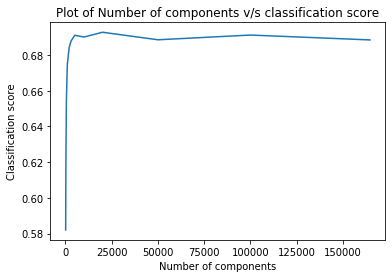

In [53]:
n_comp = [100,200,500,1000, 2000, 3000, 5000, 10000, 20000, 50000, 100000, 164634] # list containing different values of components
scores = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    t0 = time.time()
    print("vectorizing")
    tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = x, sublinear_tf = True)

    X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)
    
    X_train, X_test, y_train, y_test = train_test_split(X_data_tf, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
    print("fitting")
    rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
    rf = rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    scores.append(score)
    
    print("Number of components = %r and classification score = %r, exec time: %r s"%(x,round(score, 3), round(time.time()-t0, 2)))
    

plt.plot(n_comp, scores)
plt.xlabel('Number of components')
plt.ylabel("Classification score")
plt.title("Plot of Number of components v/s classification score")
plt.show()

A Jupyter Widget

vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 100 and classification score = 0.581, exec time: 34.53 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   29.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 200 and classification score = 0.616, exec time: 43.34 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   31.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 300 and classification score = 0.636, exec time: 45.4 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   39.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 400 and classification score = 0.644, exec time: 53.72 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   37.4s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 500 and classification score = 0.654, exec time: 51.76 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   39.9s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 600 and classification score = 0.659, exec time: 54.17 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   45.9s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 700 and classification score = 0.664, exec time: 60.1 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   43.5s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 800 and classification score = 0.665, exec time: 57.95 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   45.1s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 900 and classification score = 0.673, exec time: 59.6 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   45.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 1000 and classification score = 0.675, exec time: 59.7 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   47.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 1200 and classification score = 0.679, exec time: 61.76 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   53.1s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 1400 and classification score = 0.683, exec time: 67.47 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   53.7s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 1600 and classification score = 0.683, exec time: 68.37 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   50.9s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 1800 and classification score = 0.685, exec time: 65.15 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   56.1s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 2000 and classification score = 0.685, exec time: 70.88 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   52.9s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 2500 and classification score = 0.688, exec time: 67.76 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   53.5s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 3000 and classification score = 0.687, exec time: 68.23 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   59.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


Number of components = 3500 and classification score = 0.69, exec time: 75.12 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 4000 and classification score = 0.688, exec time: 76.46 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 4500 and classification score = 0.691, exec time: 77.94 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   59.9s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 5000 and classification score = 0.691, exec time: 74.63 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 6000 and classification score = 0.69, exec time: 80.86 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 7000 and classification score = 0.691, exec time: 82.04 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 8000 and classification score = 0.692, exec time: 84.12 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 9000 and classification score = 0.692, exec time: 82.07 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 10000 and classification score = 0.692, exec time: 88.64 s
vectorizing
fitting


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


Number of components = 20000 and classification score = 0.693, exec time: 93.87 s



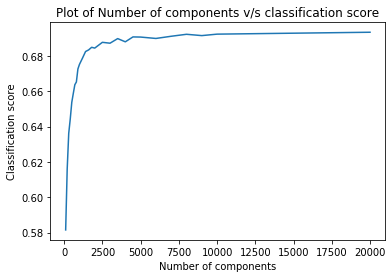

In [54]:
n_comp = [100,200,300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000, 9000, 10000, 20000] # list containing different values of components
scores = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm(n_comp):
    t0 = time.time()
    print("vectorizing")
    tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = x, sublinear_tf = True)

    X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)
    
    X_train, X_test, y_train, y_test = train_test_split(X_data_tf, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
    print("fitting")
    rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
    rf = rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    scores.append(score)
    
    print("Number of components = %r and classification score = %r, exec time: %r s"%(x,round(score, 3), round(time.time()-t0, 2)))
    

plt.plot(n_comp, scores)
plt.xlabel('Number of components')
plt.ylabel("Classification score")
plt.title("Plot of Number of components v/s classification score")
plt.show()

In [48]:
%%time
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = None, sublinear_tf = True)

X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)



CPU times: user 14.3 s, sys: 2.26 ms, total: 14.3 s
Wall time: 14.3 s


In [51]:
X_data_tf.shape

(120809, 164634)